<a href="https://colab.research.google.com/github/AI-FREE-Team/TTS-AIGO/blob/main/Text_to_Speech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![人工智慧 - 自由團隊](https://raw.githubusercontent.com/chenkenanalytic/img/master/af/aifreeteam.png)
# AI . FREE Team
* [官方網站](https://ai-free-team.github.io/)
* [FB粉絲團](https://www.facebook.com/aifreeteam)

# License

> Copyright (c) 2021, NVIDIA CORPORATION & AFFILIATES. All rights reserved.
> Licensed under the Apache License, Version 2.0 (the "License"); you may not > > use this file except in compliance with the License. You may obtain a copy of > the License at
> 
> http://www.apache.org/licenses/LICENSE-2.0
> 
> Unless required by applicable law or agreed to in writing, software > distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.


# 1. 認識 Nemo
* 使用範疇
* 文字轉語音系統 - Text-to-Speech (TTS)
* Spectrogram Generator
* Vocoder

# 2. 資料前處理(Data Preprocess)
* 匯入資料集
* 認識資料集
* 產出 Nemo 可接受的資料集格式(JSON)

## 2.0 安裝&載入套件

In [ ]:
import pandas as pd 

**需要 3-4 分鐘**

In [ ]:
BRANCH = "main"
!apt-get install sox libsndfile1 ffmpeg
!pip install wget text-unidecode
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/main/nemo_text_processing/install_pynini.sh
!bash install_pynini.sh

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1 is already the newest version (1.0.28-4ubuntu0.18.04.2).
ffmpeg is already the newest version (7:3.4.11-0ubuntu0.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3
Suggested packages:
  file libsox-fmt-all
The following NEW packages will be installed:
  libmagic-mgc libmagic1 libopencore-amrnb0 libopencore-amrwb0 libsox-fmt-alsa
  libsox-fmt-base libsox3 sox
0 upgraded, 8 newly installed, 0 to remove and 20 not upgraded.
Need to get 760 kB of archives.
After this operation, 6,717 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopencore-amrnb0 amd64 0.1.3-2.1 [92.0 kB]
Get:2 http://

In [ ]:
# Note: 有時候需要執行兩次才會成功
from nemo_text_processing.text_normalization.normalize import Normalizer

[NeMo W 2022-12-25 07:08:47 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.


In [ ]:
import IPython.display as ipd
import librosa
import random

In [ ]:
from tqdm import tqdm
import json

!pip install --upgrade matplotlib==3.1.3
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 2.1 匯入資料集
* 點擊此，下載 The LJ Speech Dataset。
* 點擊此，下載預訓練模型。
* 上傳至 Google Drive 的指定位置。
* 解壓縮至此虛擬機之根目錄

In [ ]:
# 連結 notebook 與 drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**需要 4-6 分鐘**


In [ ]:
# 請將 /path/to/LJSpeech-1.1.tar.bz2 換成正確的路徑
# !tar -xf /path/to/LJSpeech-1.1.tar.bz2 -C .
!tar -xf drive/MyDrive/AI/Datasets/NLP/TTS/LJSpeech-1.1.tar.bz2 -C .

In [ ]:
!ls 

Tacotron2_Pretrained_Models.zip


In [ ]:
! mkdir nemo

# 請將 /path/to/Tacotron2_Pretrained_Models 換成正確的路徑
# !unzip /path/to/Tacotron2_Pretrained_Models .
! unzip "drive/MyDrive/AI/Pretrained Models/NLP/TTS/Tacotron2/LJ_pretrained_models/Tacotron2_Pretrained_Models.zip" -d ./nemo

mkdir: cannot create directory ‘nemo’: File exists
Archive:  drive/MyDrive/AI/Pretrained Models/NLP/TTS/Tacotron2/LJ_pretrained_models/Tacotron2_Pretrained_Models.zip
  inflating: ./nemo/Tacotron2_10_epoch.nemo  
  inflating: ./nemo/Tacotron2_30_epoch.nemo  
  inflating: ./nemo/Tacotron2_100_epoch.nemo  
  inflating: ./nemo/Tacotron2_3_epoch.nemo  
  inflating: ./nemo/Tacotron2_200_epoch.nemo  


## 2.2 認識資料集

In [ ]:
# 讀取檔案
metadata = pd.read_csv(f"LJSpeech-1.1/metadata.csv", sep="|", header=None)

# 參考 README 命名各欄位
metadata = metadata.rename(columns={0:"ID", 1:"Transcription", 2:"Normalized_Transcription"})
metadata.head()

ID                                      Transcription  \
0  LJ001-0001  Printing, in the only sense with which we are ...   
1  LJ001-0002                     in being comparatively modern.   
2  LJ001-0003  For although the Chinese took impressions from...   
3  LJ001-0004  produced the block books, which were the immed...   
4  LJ001-0005  the invention of movable metal letters in the ...   

                            Normalized_Transcription  
0  Printing, in the only sense with which we are ...  
1                     in being comparatively modern.  
2  For although the Chinese took impressions from...  
3  produced the block books, which were the immed...  
4  the invention of movable metal letters in the ...

In [ ]:
# 觀察 Normalized 的效果
print(f"[Origianl   Transcription] {metadata['Transcription'][37]}")
print(f"[Normalized Transcription] {metadata['Normalized_Transcription'][37]}")

[Origianl   Transcription] while in 1470 at Paris Udalric Gering and his associates turned out the first books printed in France, also in Roman character.
[Normalized Transcription] while in fourteen seventy at Paris Udalric Gering and his associates turned out the first books printed in France, also in Roman character.


**需要 30 秒鐘**

In [ ]:
# Q: 後續實際應用時，該如何自動化地 Normalize 文字呢?
# A: 可使用 Nemo 提供的 nlp toolkit

# 實例化 Normalizer
normalizer = Normalizer(input_case='cased', lang='en')

[NeMo I 2022-12-25 07:09:24 tokenize_and_classify:87] Creating ClassifyFst grammars.


In [ ]:
# ------------------------------- #
# 測試 Text Normalization - 1 #
# ------------------------------- #
written = "We paid $123 for this desk."
normalized = normalizer.normalize(written, verbose=False, punct_post_process=True)
print(f"------- Test 1 -------\n[BF] {written}\n[AF] {normalized}\n")

# ------------------------------- #
# 測試 Text Normalization - 2 #
# ------------------------------- #
written = "The humidity in Taipei is 99.5%."
normalized = normalizer.normalize(written, verbose=False, punct_post_process=True)
print(f"------- Test 2 -------\n[BF] {written}\n[AF] {normalized}\n")

# ------------------------------- #
# 測試 Text Normalization - 3 #
# ------------------------------- #
# add your own tests here

------- Test 1 -------
[BF] We paid $123 for this desk.
[AF] We paid one hundred and twenty three dollars for this desk.

------- Test 2 -------
[BF] The humidity in Taipei is 99.5%.
[AF] The humidity in Taipei is ninety nine point five percent.



In [ ]:
# 計算音訊樣本時間長度
def cal_duration(path_to_wav):
  duration = librosa.get_duration(filename=path_to_wav)
  duration = round(duration, 3)
  return duration

In [ ]:
# 認識音訊樣本之基本資訊
index = random.randint(0, len(metadata))
print(f"[Original   Transcription] {metadata['Transcription'][index]}")
print(f"[Normalized Transcription] {metadata['Normalized_Transcription'][index]}")
sample_path = f"LJSpeech-1.1/wavs/{metadata['ID'][index]}.wav"
print(f"檔案路徑: {sample_path}")

x, sr = librosa.load(sample_path)
duration = cal_duration(path_to_wav=sample_path)
print(f"採樣率: {sr}, 時間長度: {duration}")
ipd.Audio(x, rate=sr)

[Original   Transcription] now more strictly meager, thanks to the inspectors and the more stringent discipline, and before he embarked for Australia to undergo his fourteen years,
[Normalized Transcription] now more strictly meager, thanks to the inspectors and the more stringent discipline, and before he embarked for Australia to undergo his fourteen years,
檔案路徑: LJSpeech-1.1/wavs/LJ012-0160.wav
採樣率: 22050, 時間長度: 10.073


## 2.3 產出 Nemo 可接受的資料集格式(JSON)
* 遵守 `nemo.collections.tts.torch.data.TTSDataset` 的格式
* 檔案路徑(audio filepath)、對應文字(text)、音訊時長(duration)(以 sec 計)
  ```python
{"audio_filepath": "/path/to/audio1.wav", "text": "the transcription", "duration": 0.82}
{"audio_filepath": "/path/to/audio2.wav", "text": "the other transcription", "duration": 2.1}
{...}
  ```

In [ ]:
# 生成對應 JSON 檔案

trn_dataset = []
val_dataset = []

trn_duration_list = list()
val_duration_list = list()
trn_total_duration = 0
val_total_duration = 0

# Traverse Dataframe 的所有資料 
for index in tqdm(range(len(metadata))):

  data_o = {}
  data_o["audio_filepath"] = f"LJSpeech-1.1/wavs/{metadata['ID'][index]}.wav" 
  
  # 發現有幾筆 Normalized Transcription 是 NaN，透過下方程式碼解決此 issue
  if type(metadata["Normalized_Transcription"][index]) != str:
    normalized = normalizer.normalize(metadata["Transcription"][index], verbose=False, punct_post_process=True)
    data_o["text"] = normalized
  else:
    data_o["text"] = metadata["Normalized_Transcription"][index]

  duration = cal_duration(f"LJSpeech-1.1/wavs/{metadata['ID'][index]}.wav")
  data_o["duration"] = duration

  # 目前是設定每 50 筆資料有 1 筆會放入驗證資料集當中，此數值可調整
  if index % 50 != 0:
    trn_dataset.append(data_o)
    trn_duration_list.append(duration)
    trn_total_duration = trn_total_duration + duration
  else:
    val_dataset.append(data_o)
    val_duration_list.append(duration)
    val_total_duration = val_total_duration + duration

# 生成 training dataset (JSON 形式)
with open("trn_dataset_LJ.json", "w") as trn_json_file:
  for trn_sample in trn_dataset:
    json.dump(trn_sample, trn_json_file)
    trn_json_file.write("\n")
  trn_json_file.close()

# 生成 validation dataset (JSON 形式)
with open("val_dataset_LJ.json", "w") as val_json_file:
  for val_sample in val_dataset:
    json.dump(val_sample, val_json_file)
    val_json_file.write("\n")
  val_json_file.close()

100%|██████████| 13100/13100 [00:05<00:00, 2557.18it/s]


In [ ]:
# 瞭解訓練與驗證資料集的時間分布
def group_duration(duration_list):
  
  group_list = [0 for _ in range(10)]

  for duration in duration_list:
    if duration > 1 and duration <= 2: group_list[0] = group_list[0] + 1
    if duration > 2 and duration <= 3: group_list[1] = group_list[1] + 1
    if duration > 3 and duration <= 4: group_list[2] = group_list[2] + 1
    if duration > 4 and duration <= 5: group_list[3] = group_list[3] + 1
    if duration > 5 and duration <= 6: group_list[4] = group_list[4] + 1
    if duration > 6 and duration <= 7: group_list[5] = group_list[5] + 1
    if duration > 7 and duration <= 8: group_list[6] = group_list[6] + 1
    if duration > 8 and duration <= 9: group_list[7] = group_list[7] + 1
    if duration > 9 and duration <= 10: group_list[8] = group_list[8] + 1
    if duration > 10 and duration <= 11: group_list[9] = group_list[9] + 1

  return group_list

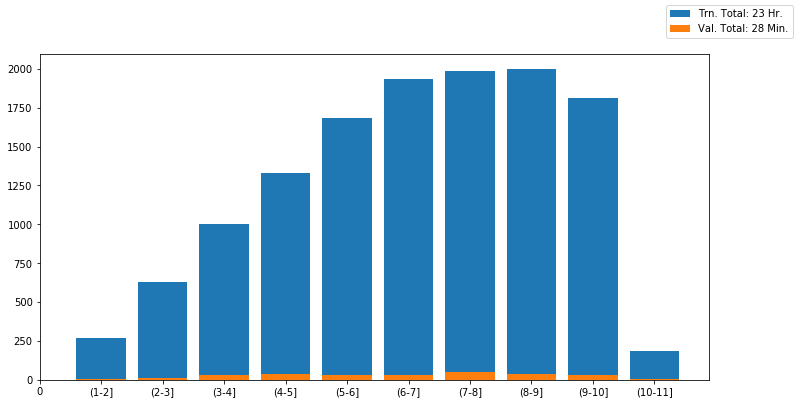

In [ ]:
trn_duration_group_list = group_duration(trn_duration_list)
val_duration_group_list = group_duration(val_duration_list)

fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(range(1,11), height=trn_duration_group_list, label=f"Trn. Total: {round(trn_total_duration/3600)} Hr.")
ax.bar(range(1,11), height=val_duration_group_list, label=f"Val. Total: {round(val_total_duration/60)} Min.")
ax.set_xticks(range(11))
ax.set_xticklabels(["0", "(1-2]", "(2-3]", "(3-4]", "(4-5]", "(5-6]", "(6-7]", "(7-8]", "(8-9]", "(9-10]", "(10-11]"])
fig.legend()
fig.show()

# 3. 訓練(Train)
* Train from scratch
* Load pre-train model and finetune

## 3.0 安裝&載入套件

In [ ]:
# 取得 tacotron2.py 與 tacotron2.yaml 

# NeMo's training scripts are stored inside the examples/ folder. Let's grab the tacotron2.py file
# as well as the tacotron2.yaml file
BRANCH = "main"
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/tacotron2.py
!(mkdir -p conf \
  && cd conf \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/tacotron2.yaml \
  && cd ..)

# We will also need a few extra files for handling text.
!(mkdir -p scripts/tts_dataset_files \
  && cd scripts/tts_dataset_files \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/cmudict-0.7b_nv22.10 \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/heteronyms-052722 \
  && cd ..)

!(mkdir -p nemo_text_processing/text_normalization/en/data/whitelist/ \
  && cd nemo_text_processing/text_normalization/en/data/whitelist/ \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/nemo_text_processing/text_normalization/en/data/whitelist/lj_speech.tsv \
  && cd ..)

--2022-12-25 06:04:34--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/tts/tacotron2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1874 (1.8K) [text/plain]
Saving to: ‘tacotron2.py’

tacotron2.py        100%[===================>]   1.83K  --.-KB/s    in 0s      

2022-12-25 06:04:34 (36.1 MB/s) - ‘tacotron2.py’ saved [1874/1874]

--2022-12-25 06:04:34--  https://raw.githubusercontent.com/NVIDIA/NeMo/main/examples/tts/conf/tacotron2.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5444 (5.3K) [text/plain]
Sav

## 3.1 Train from scratch
* 此部分之設定須同步參考 `conf/tacotron2.yaml` 的內容



**3 個 epoch 需要 50 分鐘**

In [ ]:
# 主要是針對 conf/tacotron2.yaml 中 ??? 的地方提供相關訊息
!(python tacotron2.py \
  train_dataset=trn_dataset_LJ.json \
  validation_datasets=val_dataset_LJ.json \
  trainer.max_epochs=3 \
  trainer.accelerator=null \
  trainer.check_val_every_n_epoch=1 \
 +trainer.gpus=1)

[NeMo W 2022-12-22 08:47:05 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-12-22 08:47:06 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-22 08:47:06 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-22 08:47:06 nemo_logging:349] /usr/local/lib/python3.8/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
    See https://hydra.cc/docs/next/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
      ret = run_job(
    
[NeMo W 2022-12-22 08:47:06 nemo_logging:349] /usr/local/lib/python3.8/dist-packages/pytorch_lightnin

**若有 resume 需求**
1. 在 `conf/tacotron2.yaml` 的 `exp_manager` 新增 `resume_if_exists: True`，可參考下圖。
![](https://raw.githubusercontent.com/AI-FREE-Team/TTS-AIGO/main/pictures/resume_if_exists.jpg)
2. 將目標 `checkpoints/` 上移一層至 `nemo_experiments/Tacotron2/checkpoints/`
```
! cp -r nemo_experiments/Tacotron2/2022-12-22_08-47-07/checkpoints/ nemo_experiments/Tacotron2/checkpoints/
```

In [ ]:
# 請更換 2022-12-22_08-47-07，此時間每次都會不一樣

! cp -r nemo_experiments/Tacotron2/2022-12-22_08-47-07/checkpoints/ nemo_experiments/Tacotron2/checkpoints/

In [ ]:
# 從 3 個 epoch 增加到 5 個 epoch
!(python tacotron2.py \
  train_dataset=trn_dataset_LJ.json \
  validation_datasets=val_dataset_LJ.json \
  trainer.max_epochs=5 \
  trainer.accelerator=null \
  trainer.check_val_every_n_epoch=1 \
 +trainer.gpus=1)

[NeMo W 2022-12-22 09:47:34 optimizers:55] Apex was not found. Using the lamb or fused_adam optimizer will error out.
[NeMo W 2022-12-22 09:47:35 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-22 09:47:35 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-22 09:47:35 nemo_logging:349] /usr/local/lib/python3.8/dist-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
    See https://hydra.cc/docs/next/upgrades/1.1_to_1.2/changes_to_job_working_dir/ for more information.
      ret = run_job(
    
[NeMo W 2022-12-22 09:47:35 nemo_logging:349] /usr/local/lib/python3.8/dist-packages/pytorch_lightnin

## 3.2 Load pre-train model and finetune for a new speaker
* 若有額外 Dataset 則可參考 [Fastpitch Finetune Finetune](https://github.com/NVIDIA/NeMo/blob/main/tutorials/tts/FastPitch_Finetuning.ipynb)

# 4. 推論(Inference)

## 4.0 安裝&載入套件

In [ ]:
from omegaconf import OmegaConf, open_dict
import torch
from nemo.collections.tts.models.base import SpectrogramGenerator, Vocoder
import IPython.display as ipd
import numpy as np
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline

def load_spectrogram_generator(model_name):
  override_conf = None

  if model_name == "tacotron2":
    from nemo.collections.tts.models import Tacotron2Model
    pretrained_model = "tts_en_tacotron2"
  elif model_name == "fastpitch":
    from nemo.collections.tts.models import FastPitchModel
    pretrained_model = "tts_en_fastpitch"
  else:
    pass

  from_pretrained_call = SpectrogramGenerator.from_pretrained
  spectrogram_gen = from_pretrained_call(pretrained_model, override_config_path=override_conf)
  return spectrogram_gen


def load_audio_generator(model_name):
  strict=True

  if model_name == "waveglow":
      from nemo.collections.tts.models import WaveGlowModel
      pretrained_model = "tts_waveglow"
      strict=False
  elif model_name == "univnet":
      from nemo.collections.tts.models import UnivNetModel
      pretrained_model = "tts_en_lj_univnet"
  else:
    pass

  audio_gen = Vocoder.from_pretrained(pretrained_model, strict=strict)
  return audio_gen

def infer(spec_gen_model, vocoder_model, str_input):
    parser_model = spec_gen_model
    with torch.no_grad():
        parsed = parser_model.parse(str_input)
        gen_spec_kwargs = {}
        
        spectrogram = spec_gen_model.generate_spectrogram(tokens=parsed, **gen_spec_kwargs)
        audio = vocoder_model.convert_spectrogram_to_audio(spec=spectrogram)

    if spectrogram is not None:
        if isinstance(spectrogram, torch.Tensor):
            spectrogram = spectrogram.to('cpu').numpy()
        if len(spectrogram.shape) == 3:
            spectrogram = spectrogram[0]
    if isinstance(audio, torch.Tensor):
        audio = audio.to('cpu').numpy()
    return spectrogram, audio

def plot_spectrogram(spec, audio):
  if spec is not None:
    imshow(spec, origin="lower")
    plt.show()

[NeMo W 2022-12-25 07:10:31 experimental:27] Module <class 'nemo.collections.common.tokenizers.text_to_speech.tts_tokenizers.IPATokenizer'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-25 07:10:31 experimental:27] Module <class 'nemo.collections.tts.models.radtts.RadTTSModel'> is experimental, not ready for production and is not fully supported. Use at your own risk.


## 4.1 直接使用 pre-trained model

In [ ]:
spec_model_name = "tacotron2" # 1200 epoch
voco_model_name = "univnet"
sepctrogram_gen = load_spectrogram_generator(spec_model_name).eval().cuda() # "fastpitch", "mixertts", "mixerttsx"
vocoder_gen = load_audio_generator(voco_model_name).eval().cuda() # "waveglow", "univnet" ## "hifigan", "griffin-lim"

[NeMo I 2022-12-25 07:10:36 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo.
[NeMo I 2022-12-25 07:10:36 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo
[NeMo I 2022-12-25 07:10:36 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2022-12-25 07:10:38 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharDataset
      manifest_filepath: /raid/LJSpeech/nvidia_ljspeech_train.json
      max_duration: null
      min_duration: 0.1
      trim: false
      int_values: false
      load_audio: true
      normalize: true
      sample_rate: 22050
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 48
      num_workers: 4
    
[NeMo W 2022-12-25 07:10:38 modelPT:163] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_

[NeMo I 2022-12-25 07:10:39 features:267] PADDING: 16
[NeMo I 2022-12-25 07:10:41 save_restore_connector:243] Model Tacotron2Model was successfully restored from /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_tacotron2/74d819609f47744063679b44e93a47f1/tts_en_tacotron2.nemo.
[NeMo I 2022-12-25 07:10:41 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo.
[NeMo I 2022-12-25 07:10:41 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo
[NeMo I 2022-12-25 07:10:41 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2022-12-25 07:10:42 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /data/ljspeech_train.json
      max_duration: null
      min_duration: 0.75
      n_segments: 16384
      trim: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 4
      num_workers: 4
    
[NeMo W 2022-12-25 07:10:43 modelPT:163] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /data/ljspeech_val.json
      max_duration: null
      

[NeMo I 2022-12-25 07:10:43 features:267] PADDING: 0
[NeMo I 2022-12-25 07:10:43 features:275] STFT using exact pad
[NeMo I 2022-12-25 07:10:43 features:267] PADDING: 0
[NeMo I 2022-12-25 07:10:43 features:275] STFT using exact pad
[NeMo I 2022-12-25 07:10:43 save_restore_connector:243] Model UnivNetModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo.


Input what you want the model to say: How is climate change related to global warming?


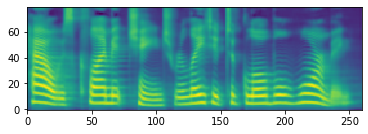

In [ ]:
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(sepctrogram_gen, vocoder_gen, text_to_generate)
plot_spectrogram(spec, audio)
ipd.Audio(audio, rate=22050)

## 4.2 使用自己訓練的 Model

In [ ]:
!cp -r "drive/MyDrive/AI/Pretrained Models/NLP/TTS/Tacotron2/nemo" "./"

### Tacotron2: 3 epochs

In [ ]:
model_path = "nemo/Tacotron2_3_epoch.nemo"
voco_model_name = "univnet"
sepctrogram_gen_3_epoch = SpectrogramGenerator.restore_from(model_path).eval().cuda()
vocoder_gen = load_audio_generator(voco_model_name).eval().cuda() # "waveglow", "univnet" ## "hifigan", "griffin-lim"

[NeMo I 2022-12-25 07:12:05 tokenize_and_classify:87] Creating ClassifyFst grammars.


[NeMo W 2022-12-25 07:12:27 experimental:27] Module <class 'nemo_text_processing.g2p.modules.IPAG2P'> is experimental, not ready for production and is not fully supported. Use at your own risk.
[NeMo W 2022-12-25 07:12:28 modules:95] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2022-12-25 07:12:28 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: trn_dataset_LJ.json
      sample_rate: 22050
      sup_data_path: null
      sup_data_types: null
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      w

[NeMo I 2022-12-25 07:12:28 features:267] PADDING: 16
[NeMo I 2022-12-25 07:12:28 features:275] STFT using exact pad
[NeMo I 2022-12-25 07:12:29 save_restore_connector:243] Model Tacotron2Model was successfully restored from /content/nemo/Tacotron2_3_epoch.nemo.
[NeMo I 2022-12-25 07:12:29 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo.
[NeMo I 2022-12-25 07:12:29 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo
[NeMo I 2022-12-25 07:12:29 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2022-12-25 07:12:30 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /data/ljspeech_train.json
      max_duration: null
      min_duration: 0.75
      n_segments: 16384
      trim: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 4
      num_workers: 4
    
[NeMo W 2022-12-25 07:12:30 modelPT:163] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /data/ljspeech_val.json
      max_duration: null
      

[NeMo I 2022-12-25 07:12:30 features:267] PADDING: 0
[NeMo I 2022-12-25 07:12:30 features:275] STFT using exact pad
[NeMo I 2022-12-25 07:12:30 features:267] PADDING: 0
[NeMo I 2022-12-25 07:12:30 features:275] STFT using exact pad
[NeMo I 2022-12-25 07:12:30 save_restore_connector:243] Model UnivNetModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo.


Input what you want the model to say: How is climate change related to global warming?


[NeMo W 2022-12-25 07:13:12 tacotron2:341] Reached max decoder steps 1000.


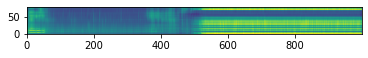

In [ ]:
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(sepctrogram_gen_3_epoch, vocoder_gen, text_to_generate)
plot_spectrogram(spec, audio)
ipd.Audio(audio, rate=22050)

### Tacotron2: 10 epochs

In [ ]:
model_path = "nemo/Tacotron2_10_epoch.nemo"
voco_model_name = "univnet"
sepctrogram_gen_10_epoch = SpectrogramGenerator.restore_from(model_path).eval().cuda()
vocoder_gen = load_audio_generator(voco_model_name).eval().cuda() # "waveglow", "univnet" ## "hifigan", "griffin-lim"

[NeMo I 2022-12-25 07:13:20 tokenize_and_classify:87] Creating ClassifyFst grammars.


[NeMo W 2022-12-25 07:13:42 modules:95] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2022-12-25 07:13:42 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: trn_dataset_LJ.json
      sample_rate: 22050
      sup_data_path: null
      sup_data_types: null
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.40639132514966


[NeMo I 2022-12-25 07:13:42 features:267] PADDING: 16
[NeMo I 2022-12-25 07:13:42 features:275] STFT using exact pad
[NeMo I 2022-12-25 07:13:43 save_restore_connector:243] Model Tacotron2Model was successfully restored from /content/nemo/Tacotron2_10_epoch.nemo.
[NeMo I 2022-12-25 07:13:43 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo.
[NeMo I 2022-12-25 07:13:43 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo
[NeMo I 2022-12-25 07:13:43 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2022-12-25 07:13:44 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /data/ljspeech_train.json
      max_duration: null
      min_duration: 0.75
      n_segments: 16384
      trim: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 4
      num_workers: 4
    
[NeMo W 2022-12-25 07:13:44 modelPT:163] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /data/ljspeech_val.json
      max_duration: null
      

[NeMo I 2022-12-25 07:13:44 features:267] PADDING: 0
[NeMo I 2022-12-25 07:13:44 features:275] STFT using exact pad
[NeMo I 2022-12-25 07:13:44 features:267] PADDING: 0
[NeMo I 2022-12-25 07:13:44 features:275] STFT using exact pad
[NeMo I 2022-12-25 07:13:44 save_restore_connector:243] Model UnivNetModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo.


Input what you want the model to say: How is climate change related to global warming?


[NeMo W 2022-12-25 07:13:49 tacotron2:341] Reached max decoder steps 1000.


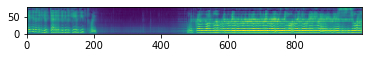

In [ ]:
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(sepctrogram_gen_10_epoch, vocoder_gen, text_to_generate)
plot_spectrogram(spec, audio)
ipd.Audio(audio, rate=22050)

### Tacotron2: 30 epochs

In [ ]:
model_path = "nemo/Tacotron2_30_epoch.nemo"
voco_model_name = "univnet"
sepctrogram_gen_30_epoch = SpectrogramGenerator.restore_from(model_path).eval().cuda()
vocoder_gen = load_audio_generator(voco_model_name).eval().cuda() # "waveglow", "univnet" ## "hifigan", "griffin-lim"

[NeMo I 2022-12-25 07:13:58 tokenize_and_classify:87] Creating ClassifyFst grammars.


[NeMo W 2022-12-25 07:14:21 modules:95] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2022-12-25 07:14:21 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: trn_dataset_LJ.json
      sample_rate: 22050
      sup_data_path: null
      sup_data_types: null
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.40639132514966


[NeMo I 2022-12-25 07:14:21 features:267] PADDING: 16
[NeMo I 2022-12-25 07:14:21 features:275] STFT using exact pad
[NeMo I 2022-12-25 07:14:21 save_restore_connector:243] Model Tacotron2Model was successfully restored from /content/nemo/Tacotron2_30_epoch.nemo.
[NeMo I 2022-12-25 07:14:21 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo.
[NeMo I 2022-12-25 07:14:21 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo
[NeMo I 2022-12-25 07:14:21 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2022-12-25 07:14:22 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /data/ljspeech_train.json
      max_duration: null
      min_duration: 0.75
      n_segments: 16384
      trim: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 4
      num_workers: 4
    
[NeMo W 2022-12-25 07:14:22 modelPT:163] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /data/ljspeech_val.json
      max_duration: null
      

[NeMo I 2022-12-25 07:14:22 features:267] PADDING: 0
[NeMo I 2022-12-25 07:14:22 features:275] STFT using exact pad
[NeMo I 2022-12-25 07:14:22 features:267] PADDING: 0
[NeMo I 2022-12-25 07:14:22 features:275] STFT using exact pad
[NeMo I 2022-12-25 07:14:22 save_restore_connector:243] Model UnivNetModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo.


Input what you want the model to say: How is climate change related to global warming?


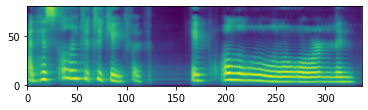

In [ ]:
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(sepctrogram_gen_30_epoch, vocoder_gen, text_to_generate)
plot_spectrogram(spec, audio)
ipd.Audio(audio, rate=22050)

### Tacotron2: 100 epochs

In [ ]:
model_path = "nemo/Tacotron2_100_epoch.nemo"
voco_model_name = "univnet"
sepctrogram_gen_100_epoch = SpectrogramGenerator.restore_from(model_path).eval().cuda()
vocoder_gen = load_audio_generator(voco_model_name).eval().cuda() # "waveglow", "univnet" ## "hifigan", "griffin-lim"

[NeMo I 2022-12-25 07:15:42 tokenize_and_classify:87] Creating ClassifyFst grammars.


[NeMo W 2022-12-25 07:16:04 modules:95] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2022-12-25 07:16:04 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: trn_dataset_LJ.json
      sample_rate: 22050
      sup_data_path: null
      sup_data_types: null
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null
      min_duration: 0.1
      ignore_file: null
      trim: false
      pitch_fmin: 65.40639132514966


[NeMo I 2022-12-25 07:16:05 features:267] PADDING: 16
[NeMo I 2022-12-25 07:16:05 features:275] STFT using exact pad
[NeMo I 2022-12-25 07:16:05 save_restore_connector:243] Model Tacotron2Model was successfully restored from /content/nemo/Tacotron2_100_epoch.nemo.
[NeMo I 2022-12-25 07:16:05 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo.
[NeMo I 2022-12-25 07:16:05 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo
[NeMo I 2022-12-25 07:16:05 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2022-12-25 07:16:06 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /data/ljspeech_train.json
      max_duration: null
      min_duration: 0.75
      n_segments: 16384
      trim: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 4
      num_workers: 4
    
[NeMo W 2022-12-25 07:16:06 modelPT:163] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /data/ljspeech_val.json
      max_duration: null
      

[NeMo I 2022-12-25 07:16:06 features:267] PADDING: 0
[NeMo I 2022-12-25 07:16:06 features:275] STFT using exact pad
[NeMo I 2022-12-25 07:16:06 features:267] PADDING: 0
[NeMo I 2022-12-25 07:16:06 features:275] STFT using exact pad
[NeMo I 2022-12-25 07:16:06 save_restore_connector:243] Model UnivNetModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo.


Input what you want the model to say: How is climate change related to global warming?


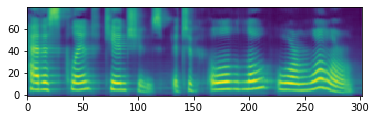

In [ ]:
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(sepctrogram_gen_100_epoch, vocoder_gen, text_to_generate)
plot_spectrogram(spec, audio)
ipd.Audio(audio, rate=22050)

### Tacotron2: 200 epochs

In [ ]:
model_path = "nemo/Tacotron2_200_epoch.nemo"
voco_model_name = "univnet"
sepctrogram_gen_200_epoch = SpectrogramGenerator.restore_from(model_path).eval().cuda()
vocoder_gen = load_audio_generator(voco_model_name).eval().cuda() # "waveglow", "univnet" ## "hifigan", "griffin-lim"

[NeMo W 2022-12-25 07:19:53 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharDataset
      manifest_filepath: nemo_dataset_LJ.json
      max_duration: null
      min_duration: 0.1
      trim: true
      int_values: false
      normalize: true
      sample_rate: 22050
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 48
      num_workers: 4
    
[NeMo W 2022-12-25 07:19:53 modelPT:163] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharDataset
      manifest_filepa

[NeMo I 2022-12-25 07:19:53 features:267] PADDING: 16
[NeMo I 2022-12-25 07:19:54 save_restore_connector:243] Model Tacotron2Model was successfully restored from /content/nemo/Tacotron2_200_epoch.nemo.
[NeMo I 2022-12-25 07:19:54 cloud:56] Found existing object /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo.
[NeMo I 2022-12-25 07:19:54 cloud:62] Re-using file from: /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo
[NeMo I 2022-12-25 07:19:54 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2022-12-25 07:19:55 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /data/ljspeech_train.json
      max_duration: null
      min_duration: 0.75
      n_segments: 16384
      trim: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 4
      num_workers: 4
    
[NeMo W 2022-12-25 07:19:55 modelPT:163] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /data/ljspeech_val.json
      max_duration: null
      

[NeMo I 2022-12-25 07:19:55 features:267] PADDING: 0
[NeMo I 2022-12-25 07:19:55 features:275] STFT using exact pad
[NeMo I 2022-12-25 07:19:55 features:267] PADDING: 0
[NeMo I 2022-12-25 07:19:55 features:275] STFT using exact pad
[NeMo I 2022-12-25 07:19:55 save_restore_connector:243] Model UnivNetModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo.


Input what you want the model to say: How is climate change related to global warming?


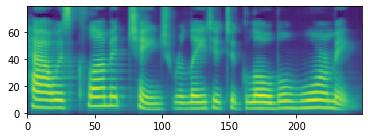

In [ ]:
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(sepctrogram_gen_200_epoch, vocoder_gen, text_to_generate)
plot_spectrogram(spec, audio)
ipd.Audio(audio, rate=22050)

# 5. 應用於原住民族語音生成的部份成果
* 雖然此部分之 pre-trained model 無法開源，不過下方還是有相對應的聲音成果可以參考


In [ ]:
model_path = "trv_nemo/Tacotron2_200_epoch.nemo"
voco_model_name = "univnet"
sepctrogram_gen = SpectrogramGenerator.restore_from(model_path).eval().cuda()
vocoder_gen = load_audio_generator(voco_model_name).eval().cuda() # "univnet" ## "hifigan", "griffin-lim"

[NeMo W 2022-12-25 06:34:26 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharDataset
      manifest_filepath: nemo_dataset_both.json
      max_duration: null
      min_duration: 0.1
      trim: true
      int_values: false
      normalize: true
      sample_rate: 22050
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 48
      num_workers: 4
    
[NeMo W 2022-12-25 06:34:26 modelPT:163] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.asr.data.audio_to_text.AudioToCharDataset
      manifest_file

[NeMo I 2022-12-25 06:34:26 features:267] PADDING: 16
[NeMo I 2022-12-25 06:34:27 save_restore_connector:243] Model Tacotron2Model was successfully restored from /content/trv_nemo/Tacotron2_200_epoch.nemo.
[NeMo I 2022-12-25 06:34:27 cloud:66] Downloading from: https://api.ngc.nvidia.com/v2/models/nvidia/nemo/tts_en_lj_univnet/versions/1.7.0/files/tts_en_lj_univnet.nemo to /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo
[NeMo I 2022-12-25 06:34:30 common:913] Instantiating model from pre-trained checkpoint


[NeMo W 2022-12-25 06:34:32 modelPT:156] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /data/ljspeech_train.json
      max_duration: null
      min_duration: 0.75
      n_segments: 16384
      trim: false
    dataloader_params:
      drop_last: false
      shuffle: true
      batch_size: 4
      num_workers: 4
    
[NeMo W 2022-12-25 06:34:32 modelPT:163] If you intend to do validation, please call the ModelPT.setup_validation_data() or ModelPT.setup_multiple_validation_data() method and provide a valid configuration file to setup the validation data loader(s). 
    Validation config : 
    dataset:
      _target_: nemo.collections.tts.data.datalayers.AudioDataset
      manifest_filepath: /data/ljspeech_val.json
      max_duration: null
      

[NeMo I 2022-12-25 06:34:32 features:267] PADDING: 0
[NeMo I 2022-12-25 06:34:32 features:275] STFT using exact pad
[NeMo I 2022-12-25 06:34:32 features:267] PADDING: 0
[NeMo I 2022-12-25 06:34:32 features:275] STFT using exact pad
[NeMo I 2022-12-25 06:34:32 save_restore_connector:243] Model UnivNetModel was successfully restored from /root/.cache/torch/NeMo/NeMo_1.14.0rc0/tts_en_lj_univnet/f0f8466125052b5fca6df7be7da06577/tts_en_lj_univnet.nemo.


**太魯閣語範例一**
* 羅馬拼字: Ubus ka hangan mu.
* 中文: 我的名字是Ubus。
  
**太魯閣語範例二**
* 羅馬拼字: Ipay ka hangan bubu mu.
* 中文: 我媽媽的名字是Ipay。
  
**太魯閣語範例三**
* 羅馬拼字: Asing ka hangan tama mu.
* 中文: 我爸爸的名字是Asing。
* 取自[原住民族語E樂園](https://web.klokah.tw/essay/)


Input what you want the model to say: Ubus ka hangan mu.


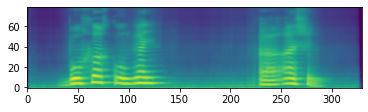

In [ ]:
# 對應範例一
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(sepctrogram_gen, vocoder_gen, text_to_generate)
plot_spectrogram(spec, audio)
ipd.Audio(audio, rate=22050)

Input what you want the model to say: Ipay ka hangan bubu mu.


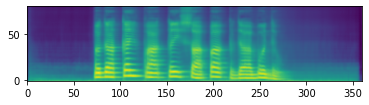

In [ ]:
# 對應範例二
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(sepctrogram_gen, vocoder_gen, text_to_generate)
plot_spectrogram(spec, audio)
ipd.Audio(audio, rate=22050)

Input what you want the model to say: Asing ka hangan tama mu.


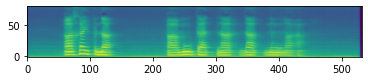

In [ ]:
# 對應範例三
text_to_generate = input("Input what you want the model to say: ")
spec, audio = infer(sepctrogram_gen, vocoder_gen, text_to_generate)
plot_spectrogram(spec, audio)
ipd.Audio(audio, rate=22050)

# 6. 引用(Reference)
* [Nvidia Nemo](https://github.com/NVIDIA/NeMo/tree/main/examples/tts)
* **[1 Ref]** [Nemo TTS Primer](https://github.com/NVIDIA/NeMo/blob/main/tutorials/tts/NeMo_TTS_Primer.ipynb)
* **[2.2 Ref]** [Text Normalization Tutorial](https://colab.research.google.com/github/NVIDIA/NeMo/blob/stable/tutorials/text_processing/Text_(Inverse)_Normalization.ipynb#scrollTo=LvBfrQVybleF)
* **[3.0 Ref]** [Tacotron 2 Training](https://github.com/NVIDIA/NeMo/blob/main/tutorials/tts/Tacotron2_Training.ipynb)
* **[3.2 Ref]** [Finetuning FastPitch for a new speaker](https://github.com/NVIDIA/NeMo/blob/main/tutorials/tts/FastPitch_Finetuning.ipynb)
* **[4.1 Ref]** [Model Select](https://github.com/NVIDIA/NeMo/blob/main/tutorials/tts/Inference_ModelSelect.ipynb)
* **[4.1 Ref]** [Tacotron2 LJSpeech Overview](https://catalog.ngc.nvidia.com/orgs/nvidia/models/tacotron2_ljspeech)
* **[5 Ref]** [原住民族語E樂園](https://web.klokah.tw/essay/)